In [1]:
import geopandas
import matplotlib.pyplot as plt
import requests
from cartogrampy.cartogram import Cartogram
import json
import pandas as pd

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

/home/max/.local/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_194532/1898072717.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.h

In [2]:
df = geopandas.read_file('shapefiles/RBS_OD_UWB_AH21.dbf') #  Geodata from https://daten.berlin.de/datensaetze/geometrien-der-wahlbezirke-f%C3%BCr-die-wahlen-zum-deutschen-bundestag-berlin-und-zum
print(df.shape)
df["weight"] = 1

(2257, 8)


In [3]:
df

,UWB,UWB3,BWB,BWB3,AWK,BEZ,BWK,geometry,weight
0,01100,100,011A,1A,0101,01,75,"POLYGON ((389486.115 5820892.998, 389396.927 5...",1
1,01101,101,011B,1B,0101,01,75,"POLYGON ((389369.003 5821657.935, 389222.620 5...",1
2,01102,102,011B,1B,0101,01,75,"POLYGON ((389369.003 5821657.935, 389374.200 5...",1
3,01103,103,011C,1C,0101,01,75,"POLYGON ((390258.845 5821359.156, 390258.267 5...",1
4,01104,104,011D,1D,0101,01,75,"POLYGON ((390647.934 5821139.037, 390467.852 5...",1
...,...,...,...,...,...,...,...,...,...
2252,12622,622,126T,6T,1206,12,77,"POLYGON ((385013.628 5830063.462, 385021.118 5...",1
2253,12623,623,126S,6S,1206,12,77,"POLYGON ((385537.430 5829991.688, 385531.442 5...",1
2254,12624,624,126U,6U,1206,12,77,"POLYGON ((384337.394 5829424.583, 384439.196 5...",1
2255,12625,625,126V,6V,1206,12,77,"POLYGON ((384961.294 5829772.877, 384962.706 5...",1


In [4]:
df.head()

,UWB,UWB3,BWB,BWB3,AWK,BEZ,BWK,geometry,weight
0,01100,100,011A,1A,0101,01,75,"POLYGON ((389486.115 5820892.998, 389396.927 5...",1
1,01101,101,011B,1B,0101,01,75,"POLYGON ((389369.003 5821657.935, 389222.620 5...",1
2,01102,102,011B,1B,0101,01,75,"POLYGON ((389369.003 5821657.935, 389374.200 5...",1
3,01103,103,011C,1C,0101,01,75,"POLYGON ((390258.845 5821359.156, 390258.267 5...",1
4,01104,104,011D,1D,0101,01,75,"POLYGON ((390647.934 5821139.037, 390467.852 5...",1


In [5]:
result_url = "https://www.tagesschau.de/wahl/archiv/2023-02-12-LT-DE-BE/karte/data-G.json?4c2b02a5-7eba-456e-a648-fe84e5ca1523"
res = requests.get(result_url)
data = json.loads(res.content)

results = data["results"]
pcolours = data["partycolors"]
parties = data["parties"]

result_list = []
for a, b in results["Gemeinden"].items():
    r = dict(zip(parties,b[0])) # Get the Zweitstimmen for each party
    r["BWB"] = a[1:]
    result_list.append(r)
result_df = pd.DataFrame(result_list)
result_df = result_df.drop(columns="BET")
parties = [x for x in parties if x!="BET"]
result_df["max"] = result_df[parties].apply(max,axis=1) # Get the maximum result in each district
for p in parties:
    print(p)
    winning_indices = result_df[p]==result_df["max"] # the districts where the party won largest share
    print(winning_indices.sum())
    result_df.loc[winning_indices,"winner"] = p
    result_df.loc[winning_indices,"colour"] = pcolours[p]
result_df = result_df.drop_duplicates(subset="BWB")

df = df.merge(result_df, how="right") # merge with the geographic data
print(df.shape)

SPD
22
GRÜNE
467
CDU
941
LINKE
51
AFD
31
FDP
0
(2257, 18)


In [6]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=0,vmax=df["max"].max())


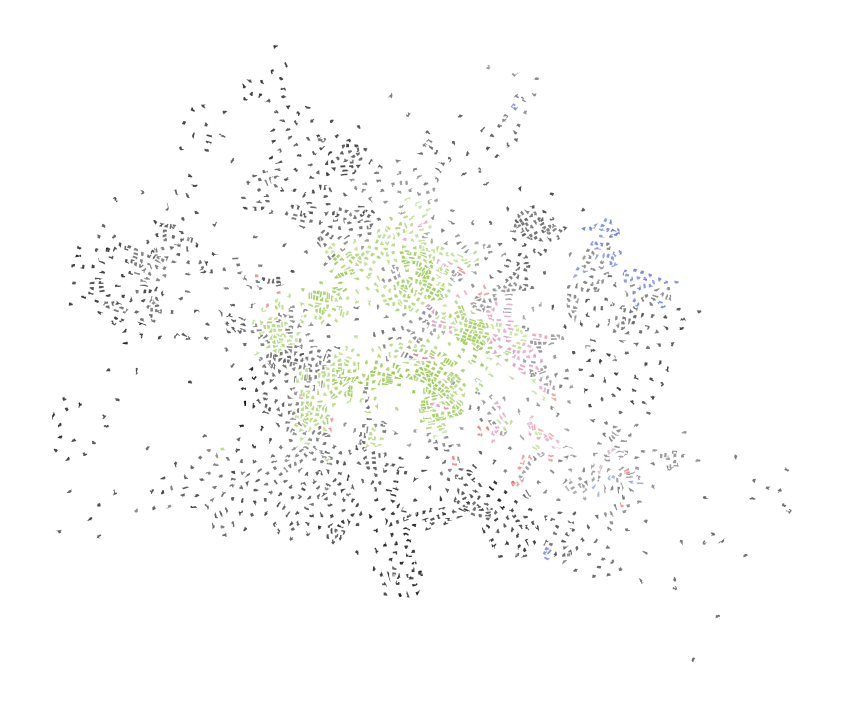

In [7]:
cgm = Cartogram(df,"weight")

noncont = cgm.noncont()

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
noncont.plot(ax=ax, color=df["colour"], alpha=norm(df["max"]))
ax.set_facecolor("white")
ax.axis("off")
plt.savefig("cartogram_sb.png",facecolor="white")

(367711.46027999965, 418074.2941200003, 5797633.363864999, 5839146.022635)

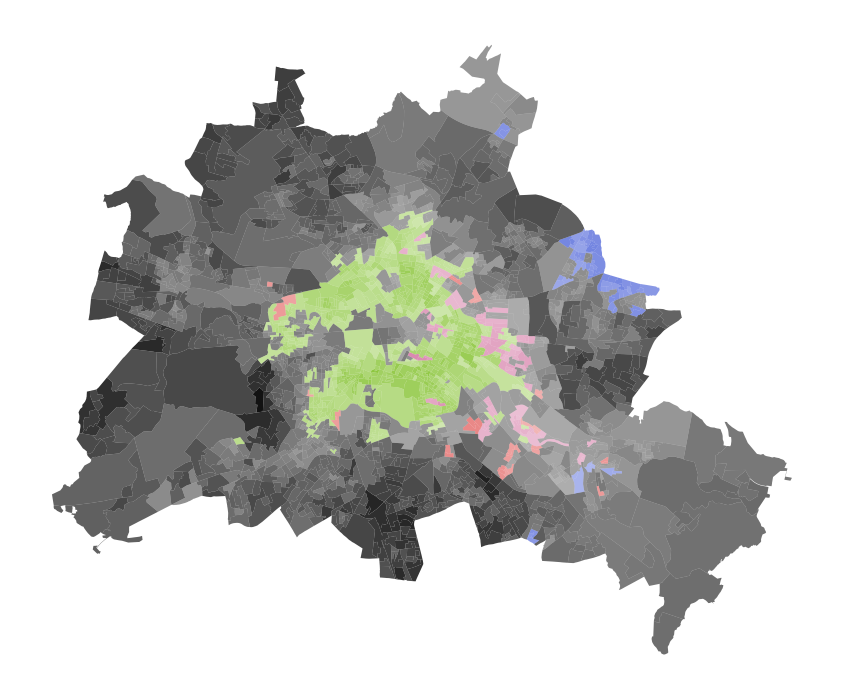

In [8]:
cgm = Cartogram(df,"weight")
noncont = cgm.noncont()

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
df.plot(ax=ax, color=df["colour"], alpha=norm(df["max"]))
ax.axis("off")

In [9]:
df["area"] = df.geometry.area

<AxesSubplot:xlabel='winner'>

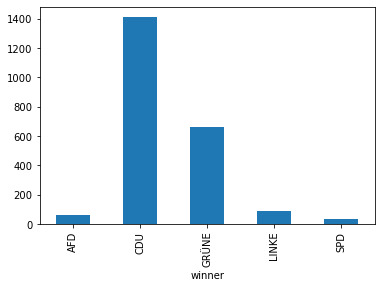

In [10]:
df.groupby("winner")["weight"].sum().plot.bar()

<AxesSubplot:xlabel='winner'>

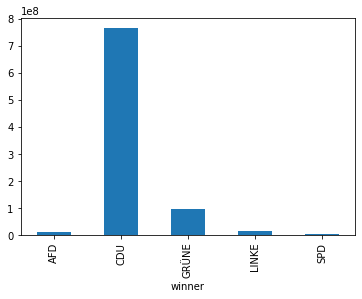

In [11]:
df
df.groupby("winner")["area"].sum().plot.bar()

## With Wahlkreise

In [12]:
df = geopandas.read_file('shapefiles/AWK_AH21_25833.dbf') #  Geodata from https://daten.berlin.de/datensaetze/geometrien-der-wahlbezirke-f%C3%BCr-die-wahlen-zum-deutschen-bundestag-berlin-und-zum
df["coordinates"] = df["geometry"].to_crs("EPSG:4326")
print(df.shape)
df["weight"] = 1
df.head()

(78, 5)


,AWK,BEZ,AWK2,geometry,coordinates,weight
0,0101,01,01,"POLYGON ((390289.028 5822077.891, 390364.719 5...","POLYGON ((13.38238 52.53773, 13.38354 52.53675...",1
1,0102,01,02,"POLYGON ((391706.255 5821165.494, 391836.942 5...","POLYGON ((13.40357 52.52981, 13.40551 52.52951...",1
2,0103,01,03,"POLYGON ((387949.698 5820853.608, 387973.990 5...","POLYGON ((13.34832 52.52625, 13.34868 52.52625...",1
3,0104,01,04,"POLYGON ((388459.424 5822711.766, 388333.649 5...","POLYGON ((13.35521 52.54305, 13.35337 52.54266...",1
4,0105,01,05,"POLYGON ((387442.563 5825063.750, 387446.634 5...","POLYGON ((13.33942 52.56398, 13.33948 52.56397...",1


[13.088345530696678, 13.761137525756295, 52.33824229748843, 52.675505954525434]


(369761.3883230714, 416239.213780842, 5799381.986837808, 5837889.081159458)

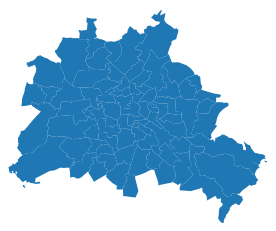

In [13]:
import cartopy.crs as ccrs
fig = plt.figure()
p = ccrs.PlateCarree()
p = ccrs.epsg(25833)

ax = plt.axes(projection=p)

bounds = df.coordinates.bounds
extent = [
    bounds.minx.min(),
    bounds.maxx.max(),
    bounds.miny.min(),
    bounds.maxy.max()
]
print(extent)
ax.set_extent(extent)


ax.add_geometries(df["coordinates"], crs=ccrs.PlateCarree())

ax.axis("off")
    

In [14]:
result_df

,SPD,GRÜNE,CDU,LINKE,AFD,FDP,BWB,max,winner,colour
0,14.6,26.8,25.2,7.5,5.0,10.2,011A,26.8,GRÜNE,#78bc1b
1,16.4,28.2,25.4,9.2,4.1,9.6,011B,28.2,GRÜNE,#78bc1b
2,15.0,29.5,21.0,10.6,4.1,10.4,011C,29.5,GRÜNE,#78bc1b
3,17.7,28.6,21.5,12.2,3.4,8.7,011D,28.6,GRÜNE,#78bc1b
4,16.8,23.0,26.9,10.7,4.2,10.5,011E,26.9,CDU,#121212
...,...,...,...,...,...,...,...,...,...,...
1502,21.3,17.6,39.8,4.0,5.4,6.9,126S,39.8,CDU,#121212
1503,20.5,12.2,45.8,2.8,7.2,6.4,126T,45.8,CDU,#121212
1504,20.4,12.2,48.1,1.4,8.0,4.7,126U,48.1,CDU,#121212
1505,25.7,12.1,34.9,5.0,8.3,6.1,126V,34.9,CDU,#121212


In [15]:
result_url = "https://www.tagesschau.de/wahl/archiv/2023-02-12-LT-DE-BE/karte/data.json?4c2b02a5-7eba-456e-a648-fe84e5ca1523"
res = requests.get(result_url)
data = json.loads(res.content)

results = data["results"]
pcolours = data["partycolors"]
parties = data["parties"]

result_list = []
for a, b in results["Wahlkreise"].items():
    r = dict(zip(parties,b[0])) # Get the Zweitstimmen for each party
    r["AWK"] = a[1:3] + "0" + a[3]
    result_list.append(r)
result_df = pd.DataFrame(result_list)
result_df = result_df.drop(columns="BET")
parties = [x for x in parties if x!="BET"]
result_df["max"] = result_df[parties].apply(max,axis=1) # Get the maximum result in each district
for p in parties:
    print(p)
    winning_indices = result_df[p]==result_df["max"] # the districts where the party won largest share
    print(winning_indices.sum())
    result_df.loc[winning_indices,"winner"] = p
    result_df.loc[winning_indices,"colour"] = pcolours[p]
result_df = result_df.drop_duplicates(subset="AWK")

df = df.merge(result_df, how="right") # merge with the geographic data
print(df.shape)

SPD
0
GRÜNE
24
CDU
50
LINKE
2
AFD
2
FDP
0
(78, 15)


In [16]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=0,vmax=df["max"].max())

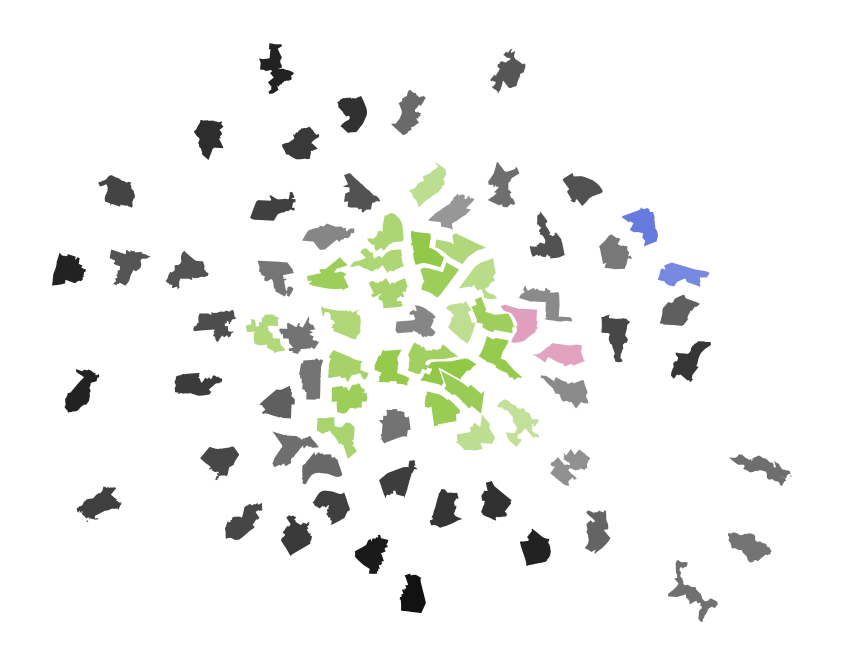

In [17]:
cgm = Cartogram(df,"weight")

noncont = cgm.noncont()

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
noncont.plot(ax=ax, color=df["colour"], alpha=norm(df["max"]))
ax.set_facecolor("white")
ax.axis("off")
plt.savefig("cartogram.png",facecolor="white")

(367711.46027999965, 418074.2941200003, 5797633.363864999, 5839146.022635)

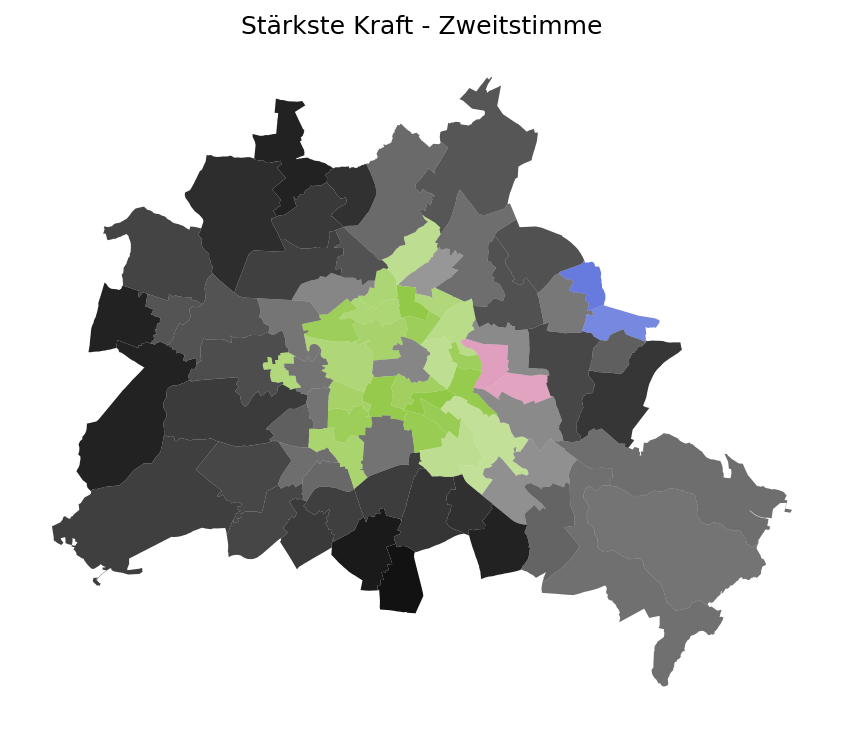

In [18]:
cgm = Cartogram(df,"weight")
noncont = cgm.noncont()

fig, ax = plt.subplots(figsize=(7,7), dpi=150)
df.plot(ax=ax, color=df["colour"], alpha=norm(df["max"]))
ax.set_title("Stärkste Kraft - Zweitstimme")
ax.axis("off")

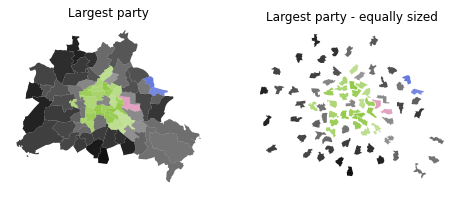

In [19]:
fig, axs = plt.subplots(1,2, figsize=(8,4))

df.plot(ax=axs[0], color=df["colour"], alpha=norm(df["max"]))
axs[0].set_title("Largest party")

noncont.plot(ax=axs[1], color=df["colour"], alpha=norm(df["max"]))
axs[0].axis("off")
axs[1].axis("off")

axs[1].set_title("Largest party - equally sized")

plt.savefig("cartogram_comparison.png",facecolor="white")

SPD
0.0
GRÜNE
12.275068442959634
CDU
85.37588550356227
LINKE
1.113033413258854
AFD
1.2360126402192413
FDP
0.0


Text(0.5, 1.0, 'Share of votes')

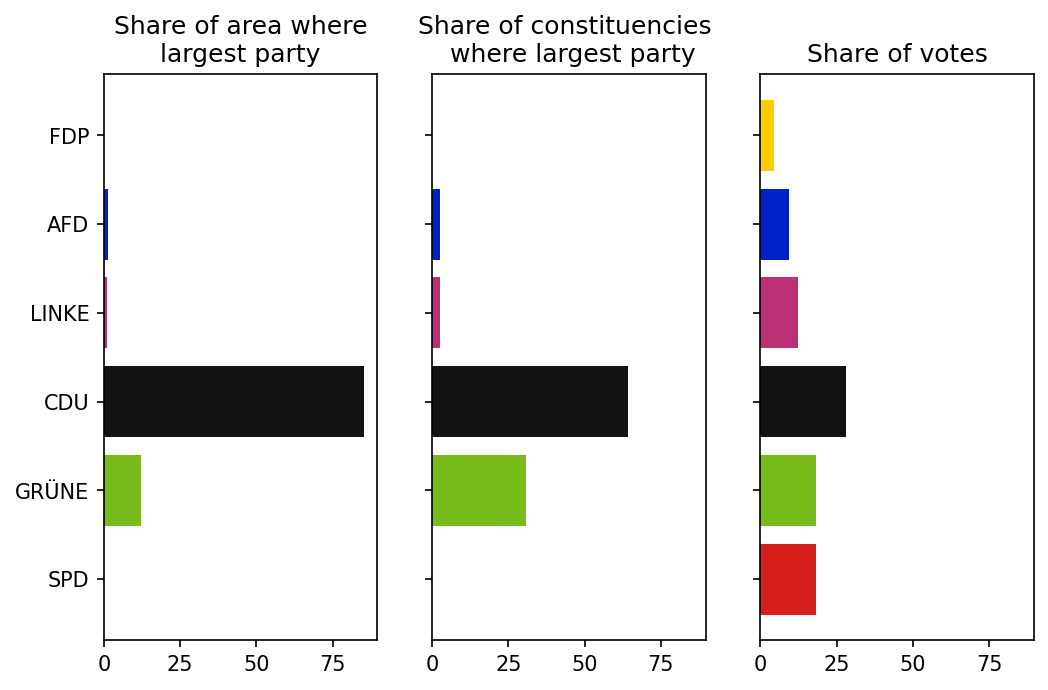

In [20]:
fig, axs = plt.subplots(1,3, figsize=(8,5), sharey=True, sharex=True, dpi=150)

df["area"] = df.geometry.area
area_sums = []
seat_sums = []
for i,p in enumerate(parties):
    print(p)
    winning_indices = df[p]==df["max"] # the districts where the party won largest share
    area_sum = df.loc[winning_indices,"area"].sum() / df["area"].sum() * 100
    print(area_sum)
    axs[0].barh(i,area_sum, color=pcolours[p])
    axs[1].barh(i, winning_indices.sum()/df.shape[0] * 100, color=pcolours[p])
    axs[2].barh(i, df[p].mean(), color=pcolours[p])
    
axs[0].set_yticks(range(len(parties)))
axs[0].set_yticklabels(parties)


axs[0].set_title("Share of area where\nlargest party")
axs[1].set_title("Share of constituencies \n where largest party")
axs[2].set_title("Share of votes")



(369761.3883230714, 416239.213780842, 5799381.986837808, 5837889.081159458)

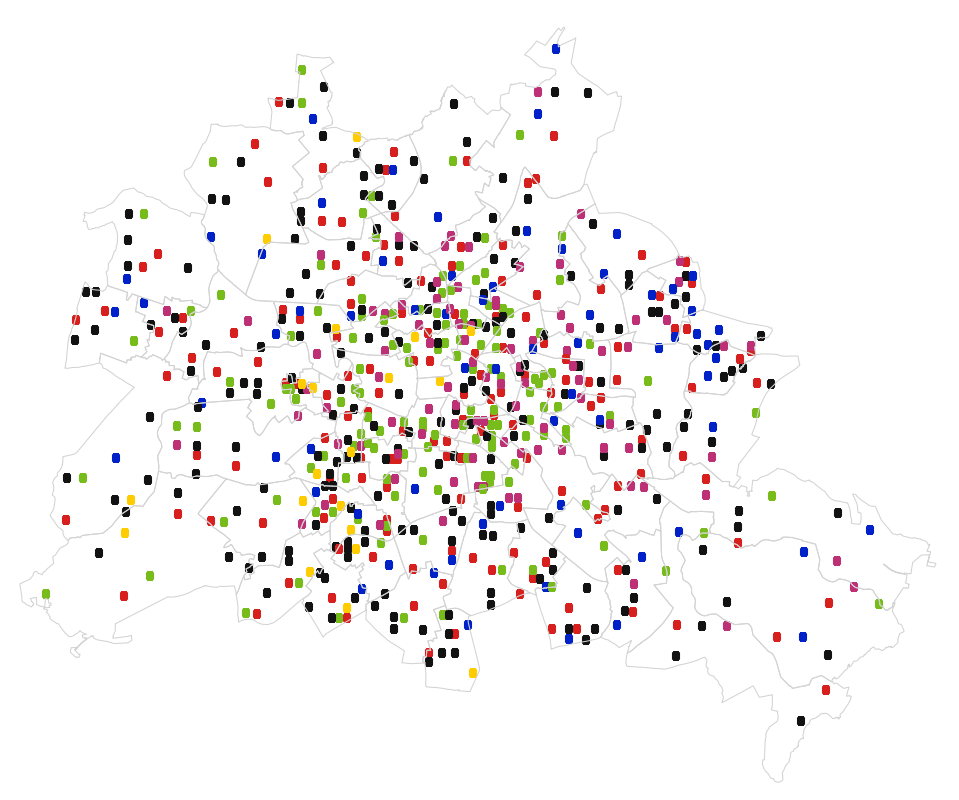

In [21]:
import numpy as np
import random
from shapely import Point
fig = plt.figure(figsize=(8,8), dpi=150)
p = ccrs.epsg(25833)

ax = fig.add_subplot(projection=p)
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    x = (np.linspace(min_x,max_x,num_points))
    y = (np.linspace(min_y,max_y,num_points))
    xx,yy = np.meshgrid(x,y,sparse=True)
    xx = xx.reshape((np.prod(xx.shape),))
    yy = yy.reshape((np.prod(yy.shape),))

    points = []

    for x in xx:
        for y in yy:
            random_point = Point([x, y])
            if (random_point.within(poly)):
                points.append(random_point.coords)
    
    return random.sample(points,num_points)

ax.set_extent(extent)

n_points = 10

for i, row in df.iterrows():
    points = random_points_within(row["coordinates"], n_points)
    ind = 0
    for p in parties:
        share = round(row[p] / 100*n_points)
        p_points = points[ind:ind+share]
        ind+=share
        x = [x[0][0] for x in p_points]
        y = [x[0][1] for x in p_points]
        ax.scatter(
            x,y, 
            transform=ccrs.PlateCarree(), 
            s=8, fc=pcolours[p], #ec="lightgrey", lw=0.01,
            marker="s"
        )

ax.add_geometries(
    df.coordinates, crs=ccrs.PlateCarree(), 
    fc="None",
    ec="lightgrey",
    lw=0.5
)

ax.axis("off")